# Introduction to Tensorflow - A Shallow, Simple Logistic Classifier

In this notebook the basic building blocks of a classifer in Tensorflow are explained:

  *  Creating a variable tensor with tf.Variable().
  *  Variable initialisation.
  *  Initialisation strategy for weights and bias.
  *  Softmax function in tensorflow
  *  Cross Entropy as cost function
  *  Example classifier for notMNIST dataset
  *  Saving a model


## Linear functions in TensorFlow

The most common operation in neural networks is calculating the linear combination of inputs, weights, and biases. 

$
y = xW + b
$

Here, W is a matrix of the weights connecting two layers. The output y, the input x, and the biases b are all vectors.

### Weights and Bias in TensorFlow

The goal of training a neural network is to modify weights and biases to best predict the labels. In order to use weights and bias, you'll need a Tensor that can be modified. This leaves out `tf.placeholder()` and `tf.constant()`, since those Tensors can't be modified. This is where `tf.Variable` class comes in.

#### tf.Variable()

x = tf.Variable(5)

The `tf.Variable` class creates a tensor with an initial value that can be modified, much like a normal Python variable. This tensor stores its state in the session, so you must initialize the state of the tensor manually. This is done using the `tf.global_variables_initializer()` function to initialize the state of all the Variable tensors.

### Initialization

```python
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
```

The `tf.global_variables_initializer()` call returns an operation that will initialize all TensorFlow variables from the graph. The operation is called using a session to initialize all the variables as shown above. Using the `tf.Variable` class allows us to change the weights and bias, but an initial value needs to be chosen.

Initializing the weights with random numbers from a normal distribution is good practice. Randomizing the weights helps the model from becoming stuck in the same place every time it is trained. 

Similarly, choosing weights from a normal distribution prevents any one weight from overwhelming other weights. The `tf.truncated_normal()` function can be used to generate random numbers from a normal distribution.

#### tf.truncated_normal()

```python
n_features = 120
n_labels = 5
weights = tf.Variable(tf.truncated_normal((n_features, n_labels)))
```

The `tf.truncated_normal()` function returns a tensor with random values from a normal distribution whose magnitude is no more than 2 standard deviations from the mean.

Since the weights are already helping prevent the model from getting stuck, you don't need to randomize the bias. Let's use the simplest solution, setting the bias to 0.

#### tf.zeros()

```python
n_labels = 5
bias = tf.Variable(tf.zeros(n_labels))
```

The `tf.zeros()` function returns a tensor with all zeros.

### Softmax in Tensorflow

The softmax function squashes it's inputs, typically called logits or logit scores, to be between 0 and 1 and also normalizes the outputs such that they all sum to 1. This means the output of the softmax function is equivalent to a categorical probability distribution. It's the typical function to use as the output activation for a network predicting multiple classes.

In [1]:
import tensorflow as tf

logit_data = [2.0, 1.0, 0.1]
logits = tf.placeholder(tf.float32)

softmax = tf.nn.softmax(logits)
sum_softmax = tf.reduce_sum(softmax)

with tf.Session() as sess:
    sm, sum_sm = sess.run((softmax, sum_softmax), feed_dict={logits: logit_data})
    print('Softmax output: ' +  str(sm))
    print('Sum: ' + str(sum_sm)) 

Softmax output: [ 0.65900117  0.24243298  0.09856589]
Sum: 1.0


### Cross Entropy in TensorFlow

Cross entropy can be used as the loss function for classification with one-hot encoded labels. 

$$
D(\hat{\textbf{y}}, \textbf{y}) = - \sum_{j} y_{j}\ln \hat{y}_{j}
$$
Where $\hat{\textbf{y}}$ is the softmax output and $\textbf{y}$ is the one-hot encoded label

TensorFlow has a function to do the cross entropy calculations.


In [2]:
softmax_data = [0.7, 0.2, 0.1]
one_hot_data = [1.0, 0.0, 0.0]

softmax = tf.placeholder(tf.float32)
one_hot = tf.placeholder(tf.float32)

# Calculate cross entropy from session
cross_entropy = -tf.reduce_sum(tf.multiply(one_hot, tf.log(softmax)))

with tf.Session() as sess:
    print(sess.run(cross_entropy, feed_dict={softmax: softmax_data, one_hot: one_hot_data}))


0.356675


### Train Model to predict notMNIST

The MNIST data in the in the repo consists of images of number from 0 to 9 in different fonts.
The data has been pre-processed to:
* Perform scaling on the pixel data to range 0 - 1. Min Max scalinng:  $ X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}} $

* One-hot encode labeled data

In [3]:
%matplotlib inline

# Load the modules
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True, reshape=False)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [5]:
train_features = mnist.train.images
train_labels = mnist.train.labels
valid_features = mnist.validation.images
valid_labels = mnist.validation.labels
test_features = mnist.test.images
test_labels = mnist.test.labels

In [6]:
n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)

# tf Graph input
features_original = tf.placeholder(tf.float32, [None, 28, 28, 1])
features = tf.reshape(features_original, [-1, n_input])
labels = tf.placeholder(tf.float32, [None, n_classes])

# Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((n_input, n_classes)))
biases = tf.Variable(tf.zeros(n_classes))

# Feed dicts for training, validation, and test session
train_feed_dict = {features_original: train_features, labels: train_labels}
valid_feed_dict = {features_original: valid_features, labels: valid_labels}
test_feed_dict = {features_original: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss - Mean of the cross entropy 
loss = tf.reduce_mean(cross_entropy)

In [7]:
# Define batch size and model hyperparameters
batch_size = 128
epochs = 5
learning_rate = 0.1

# Optimiser - Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))

# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))   

In [8]:
# Print shapes of tensors
with tf.Session() as session:
    session.run(init)
    f,w,l = session.run([features,weights,labels], feed_dict=train_feed_dict)
    print(f.shape)
    print(w.shape)
    print(l.shape)


(55000, 784)
(784, 10)
(55000, 10)


### Save Model 

Training a model can take hours. By closing a TensorFlow session, all the trained weights and biases are lost. To reuse the model in the future, one would have to train it all over again.

TensorFlow has the ability to save the training progress using a class called `tf.train.Saver`. This class provides the functionality to save any `tf.Variable` to the file system.

As can be seen below, when restoring, the weights and bias Tensors in Python still need to created. The `tf.train.Saver.restore()` function loads the saved data into weights and bias.

Since `tf.train.Saver.restore()` sets all the TensorFlow Variables, you don't need to call `tf.global_variables_initializer()`.

Epoch  5/5: 100%|██████████| 430/430 [00:03<00:00, 110.80batches/s]


Trained Model Saved.


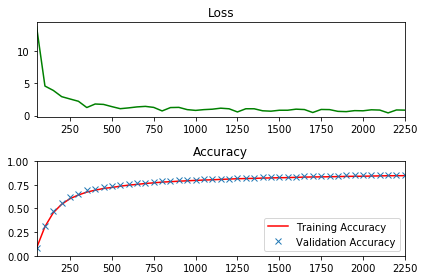

Validation accuracy at 0.8532000184059143


In [9]:
# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# Save location 
save_file = './train_model.ckpt'
saver = tf.train.Saver()

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run([optimizer, loss],
                               feed_dict={features_original: batch_features, 
                                          labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
    
    # Save the model
    saver.save(session, save_file)
    print('Trained Model Saved.')

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

###  Finetune and Test the model against your hold out dataset/testing data.

In [10]:
# The accuracy measured against the test set
test_accuracy = 0.0

# Restore location
saver = tf.train.Saver()

with tf.Session() as session:
    
    # Restore model from file
    saver.restore(session, save_file)
    
    # Fine tune for another epoch
    batch_count = int(math.ceil(len(train_features)/batch_size))
        
    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(1, 1), unit='batches')

    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = train_labels[batch_start:batch_start + batch_size]

        # Run optimizer
        _ = session.run(optimizer, feed_dict={features_original: batch_features, labels: batch_labels})

    # Check accuracy against Test data
    test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
    print(test_accuracy)

Epoch  1/1: 100%|██████████| 430/430 [00:00<00:00, 806.17batches/s]

0.8618
